In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution

In [2]:
input_parameters = {'f_layer_thickness': 200.0E3,
                    'delta_t_icb': 10.0,
                    'xfe_outer_core': 0.92,
                    'xfe_icb': 0.92,
                    'growth_prefactor': 150.0,
                    'chemical_diffusivity': 1.0E-9,
                    'kinematic_viscosity': 1.0E-6,
                    'i0': 1.0E-10,
                    'surf_energy': 1.08E-2, 
                    'number_of_analysis_points': 20,
                    'r_icb': 1221.5E3, 
                    'r_cmb': 3480.0E3,
                    'gruneisen_parameter': 1.5}

solutions, analysis_radii, particle_densities, calculated_seperation, solid_vf, \
        particle_radii, partial_particle_densities, growth_rate, opt_xl = flayer.flayer_case(**input_parameters)

input_parameters["solutions"] = solutions
input_parameters["analysis_radii"] = analysis_radii
input_parameters["particle_densities"] = particle_densities
input_parameters["calculated_seperation"] = calculated_seperation
input_parameters["solid_vf"] = solid_vf
input_parameters["particle_radii"] = particle_radii
input_parameters["partial_particle_densities"] = partial_particle_densities
input_parameters["growth_rate"] = growth_rate
input_parameters["opt_xl"] = opt_xl

print("Done, inner core growth rate is", growth_rate, "km/Myr")

/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


R = 1221500.0 I =  9.473056363807186e-11 r0 =  3.0309112983643827e-10
R = 1232026.3157894737 I =  9.413451375036342e-11 r0 =  3.201755296354433e-10
R = 1242552.6315789474 I =  9.371298940099209e-11 r0 =  3.3174664323307083e-10
R = 1253078.9473684211 I =  9.290066277377325e-11 r0 =  3.531780663040162e-10
R = 1263605.2631578948 I =  9.228119954657187e-11 r0 =  3.6875912145762385e-10
R = 1274131.5789473685 I =  9.11514553433812e-11 r0 =  3.9590209777539374e-10
R = 1284657.894736842 I =  9.023654347283388e-11 r0 =  4.167704683573351e-10
R = 1295184.2105263157 I =  8.855456548263956e-11 r0 =  4.531914420127784e-10
R = 1305710.5263157894 I =  8.712958163664585e-11 r0 =  4.823372522029454e-10
R = 1316236.8421052631 I =  8.446570166066654e-11 r0 =  5.337661792884907e-10
R = 1326763.1578947369 I =  8.208901022363187e-11 r0 =  5.769455482155814e-10
R = 1337289.4736842106 I =  7.752327916021508e-11 r0 =  6.550678857628528e-10
R = 1347815.7894736843 I =  7.319947626713503e-11 r0 =  7.2492656962892

/Users/andrewwalker/Code/slurry/falling.py:165: RuntimeWarning: invalid value encountered in double_scalars
  delta_u = (fr/re)**(0.5) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:171: RuntimeWarning: invalid value encountered in double_scalars
  delta_c = fr**(1/6) / (re**(1/6) * pe_c**(1/6)) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:172: RuntimeWarning: invalid value encountered in double_scalars
  delta_t = fr**(1/6) / (re**(1/6) * pe_t**(1/6)) * 2.0 * radius


Skipping this solution as no crystals form

ODE solved for all nuclation depths... calculating integrals over nuclation depth for inner core growth
Inner core growth rate: 5.219168353223278e-10 m/s
Inner core growth rate: 16.459169318724932 km/Myr (or mm/yr)


/Users/andrewwalker/Code/slurry/falling.py:165: RuntimeWarning: invalid value encountered in double_scalars
  delta_u = (fr/re)**(0.5) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:171: RuntimeWarning: invalid value encountered in double_scalars
  delta_c = fr**(1/6) / (re**(1/6) * pe_c**(1/6)) * 2.0 * radius
/Users/andrewwalker/Code/slurry/falling.py:172: RuntimeWarning: invalid value encountered in double_scalars
  delta_t = fr**(1/6) / (re**(1/6) * pe_t**(1/6)) * 2.0 * radius


Skipping this solution as no crystals form

ODE solved for all nuclation depths... calculating integrals over nuclation depth for inner core growth
Inner core growth rate: 5.17952013593686e-10 m/s
Inner core growth rate: 16.334134700690484 km/Myr (or mm/yr)
Ar r = 1221500.0 m, particle density =  0.0 per m^3, calculated seperation radius =  inf m
Ar r = 1232026.3157894737 m, particle density =  816.4059794766486 per m^3, calculated seperation radius =  0.06637457265368943 m
Ar r = 1242552.6315789474 m, particle density =  836.7591852551976 per m^3, calculated seperation radius =  0.0658319875885735 m
Ar r = 1253078.9473684211 m, particle density =  870.6883807941415 per m^3, calculated seperation radius =  0.06496551425561052 m
Ar r = 1263605.2631578948 m, particle density =  891.8493658694196 per m^3, calculated seperation radius =  0.06444758197833356 m
Ar r = 1274131.5789473685 m, particle density =  928.2075388982583 per m^3, calculated seperation radius =  0.06359487232465372 m
Ar

In [3]:
import pickle

In [4]:
with open('data.pickle', 'wb') as f:
    pickle.dump(input_parameters, f)

In [5]:
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)

/Users/andrewwalker/miniforge3/envs/py39/lib/python3.9/site-packages/numpy/lib/function_base.py:2197: RuntimeWarning: invalid value encountered in find_liquidus (vectorized)
  outputs = ufunc(*inputs)


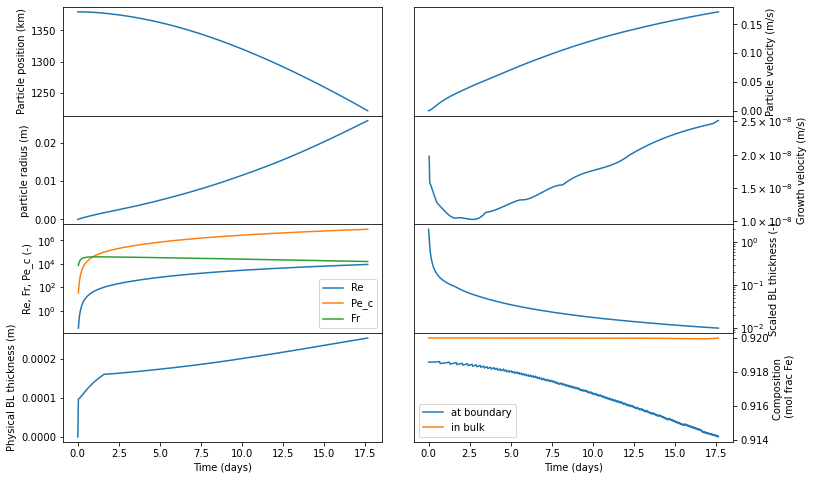

In [6]:

tfunc, tafunc, xfunc, pfunc, gfunc = flayer.setup_flayer_functions(**data)
xl_func = spi.interp1d(data["analysis_radii"], data["opt_xl"], fill_value='extrapolate')

particle_evolution.plot_particle_evolution_time(data["solutions"][-5], xl_func, tfunc, pfunc, data['chemical_diffusivity'],
                                                data['growth_prefactor'], gfunc, data['kinematic_viscosity'])